In [67]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from math import e,pi,sin

Simulating Narrowband Sources

Let :

No of Sources = N = 5  
No of Recievers = M = 10  
No of Time Snapshots of Recieved Signal = p = 100   
Frequency of Source = fc = 10^6 Hz   
Sampling Frequency at Sensors = fs = 10^7 Hz   
(=> Time Values for Snapshots are 1/fs, 2/fs, ... , p/fs)    

Source Signal : A * exp(j * 2 * pi * fc * t)     where A ~ Gaussian(0,1)  




In [141]:
N=5
M=10
p=10000
fc=1e6
fs=1e7

Generating Source Signals

In [142]:
#Fixing Amplitudes for each Source 
amp = np.random.normal(loc=100,scale=1,size=N)
print("Amplitudes=\n",amp)

#Generating Source Signal : pxN
s = np.zeros((p,N),dtype=complex)
for t in np.arange(start=1,stop=p+1):
    t_val = t/fs
    s[t-1] = np.exp(1j*2*pi*fc*t_val)*amp
print("s=\n",s.shape)

Amplitudes=
 [100.5042753   99.24928075  99.9845959   99.56241922 100.81797022]
s=
 (10000, 5)


Getting the Reciever Signals after Effect of Delay (using Steering Matrix) and Mixing with Noise   

Assume Incident DOAs are 20,50,85,110,145 degrees respectively for the sources, we will find these values using MUSIC algorithm.

Assume signal travels as speed of light = c = 3* 10^8 m/s

Assume Reciever Antenas are spaced at d=150 m in a straight line

In [143]:
#storing DOAs in radians
doa = np.array([20,50,85,110,145])*pi/180

c = 3*1e8
d = 10

#Steering Vector as a function of theta
def a(theta):
    a1 = np.exp(-1j*2*pi*fc*d*(np.sin(theta)/c) * np.arange(M) )
    return a1.reshape((M,1))
#print(a(2))

A = np.zeros((M,N),dtype=complex)
for i in range(N):
    A[:,i] = a(doa[i])[:,0]

print("A=\n",A.shape)

A=
 (10, 5)


Recieved Signal x(t) = A(theta)*s(t) + n(t), where n(t) is White Gaussian Noise for each reciever

In [144]:
X = np.zeros((p,M),dtype=complex)
for t in range(p):
    X[t] = ( A@(s[t].reshape((N,1))) + np.random.normal(loc=0,scale=1,size=(M,1)) ).reshape((M))
    
print("X=\n",X.shape)

X=
 (10000, 10)


Application of MUSIC Algorithm:   
    
    When recieved signal data (X), source frequency (fc), no of sources(M), is known, we can find the DOA for each source signal using MUltiple Signal Classification Algorithm. 

In [145]:
#finding covariance matrix of X
S = X.T@X/(p-1)

#finding eigen values and eigen vectors
eigvals, eigvecs = np.linalg.eig(S)

#finding norm of eigvals so that they can be sorted in decreasing order
eignorms = np.abs(eigvals)

#sorting eig vals and eig vecs in decreasing order of eig vals
idx = eignorms.argsort()[::-1]   
eignorms = eignorms[idx]
eigvals = eigvals[idx]
eigvecs = eigvecs[:,idx]
# print("eigvals=",eigvals)
# print("eigvecs=\n",eigvecs)

# print(S@eigvecs[:,0]/eigvecs[:,0])

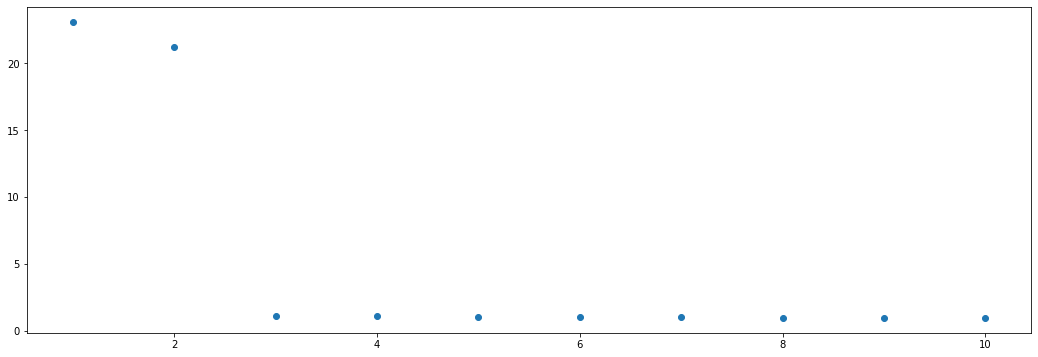

In [146]:
fig, ax = plt.subplots(figsize=(18,6))
ax.scatter(np.arange(1,len(eigvals)+1),eignorms)

In [147]:
#separating source and noise eigvectors
Us, Un = eigvecs[:,:N], eigvecs[:,N:]
print(Us.shape)

(10, 5)


In [148]:
def P_MU(theta):
#     print(a(theta).conj().T.shape)
#     print(Us.shape)
#     print(np.linalg.norm(a(theta).conj().T@Us))
    return(1/np.linalg.norm(a(theta).conj().T@Us))**2
    
print(P_MU(2))

0.10861730380907846


In [149]:
#searching for all possible theta
theta_vals = np.linspace(0,360,10000)
P_MU_vals = np.array([P_MU(val*pi/180.0) for val in theta_vals])
print(P_MU_vals.shape)


(10000,)


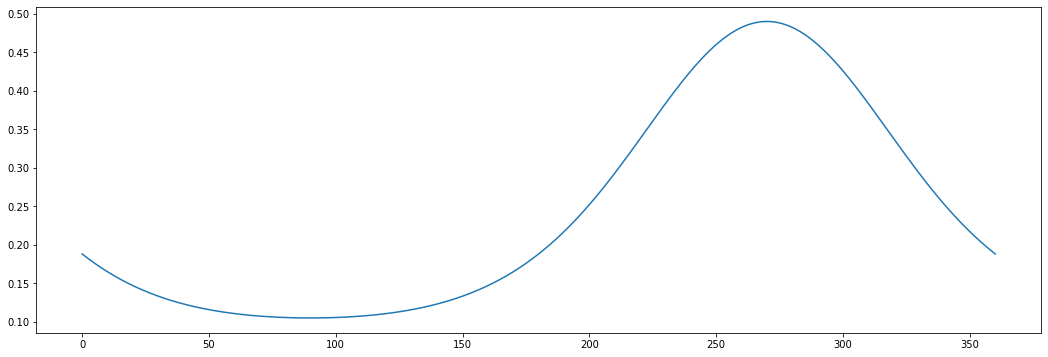

In [150]:
fig, ax = plt.subplots(figsize=(18,6))
plt.plot(theta_vals,P_MU_vals)

In [151]:
#Get top N DOAs
idx = P_MU_vals.argsort()[::-1] 
DOA_estimated = theta_vals[idx]
print(DOA_estimated[:1000])

[269.9909991  270.0270027  269.9549955  270.0630063  269.9189919
 270.0990099  269.8829883  270.1350135  269.8469847  270.1710171
 269.8109811  270.2070207  269.7749775  270.2430243  269.7389739
 270.2790279  269.7029703  270.3150315  269.6669667  270.3510351
 269.6309631  270.3870387  269.5949595  270.4230423  269.5589559
 270.4590459  269.5229523  270.4950495  269.48694869 270.53105311
 269.45094509 270.56705671 269.41494149 270.60306031 269.37893789
 270.63906391 269.34293429 270.67506751 269.30693069 270.71107111
 269.27092709 270.74707471 269.23492349 270.78307831 269.19891989
 270.81908191 269.16291629 270.85508551 269.12691269 270.89108911
 269.09090909 270.92709271 269.05490549 270.96309631 269.01890189
 270.99909991 268.98289829 271.03510351 268.94689469 271.07110711
 268.91089109 271.10711071 268.87488749 271.14311431 268.83888389
 271.17911791 268.80288029 271.21512151 268.76687669 271.25112511
 268.73087309 271.28712871 268.69486949 271.32313231 268.65886589
 271.35913591 2